In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from astropy.stats import sigma_clipped_stats
from scipy.signal import convolve

import sys
sys.path.append('../space_checker/')
from match_target import *
import external_photometry as ep

from astropy.coordinates import SkyCoord
import astropy.units as u
c1 = SkyCoord(56.88857553, -45.39215971,unit=u.deg)
c2 = SkyCoord(56.88721119, -45.38894206,unit=u.deg)
c3 = SkyCoord(56.88750846,-45.39534694,unit=u.deg)


class prob_association():
    def __init__(self,ra,dec,era=None,edec=None,lc=None,verbose=1,zp=25):
        self.ra = ra
        self.dec = dec
        self.era = era
        self.edec = edec
        self.lc = lc#np.array(lc)
        self.verbose = verbose

        self._check_params()



    def _check_params(self):
        #if (np.isfinite(self.ra)) & (np.isfinite(self.dec) #(len(self.ra) != len(self.dec)):
        #    raise ValueError('ra and dec must be the same length')
        if type(self.lc) == str:
            self.lc = pd.read_csv(self.lc)
        if not (self.lc.keys().values == 'event').any():
            if self.verbose > 0:
                print('No event column detected in lc, attempting to set one')
            lc = self.lc
            lc['event'] = 0
            mean,med,std = sigma_clipped_stats(lc['counts'].values)
            lc.loc[lc['counts'] > (med + 5*std),'event'] = 1
        if (self.lc is None) & (self.verbose > 0):
            print('No lightcurve specified')
        #else:
        #    if self.lc is not None:
        #        if len(self.lc.shape) < 3:
        #            print
        if self.era is None:
            m = "No positional error provided, assuming an error of 10''"
            print(m)
            self.era =  10/60**2
            self.edec =  10/60**2

    def get_external(self,ra = None, dec = None, pos_error = None,index=None,imsize=100):
        if ra is None:
            ra = self.ra 
            dec = self.dec
        if pos_error is None:
            pos_error = [self.era,self.edec]

        #if len(ra) > 1:
        #    if index is None:
        #        m = '!! Only 1 coordinate can be queried, and no index is set.\nSetting index = 0 !!'
        #        warnings.warn(m)
        #        index = 0
        #    ra = ra[index]; dec = dec[index]; pos_error = pos_error[index]

        coords = [ra,dec]
        fig, wcs, outsize, phot, cat, image = event_cutout(coords,error=pos_error,size=imsize)

        cat['g-r'] = cat['gmag'] - cat['rmag']

        self.phot_wcs = wcs
        self.fig = fig 
        self.instrument = phot
        self.cat = cat
        self.image = image



    def _compute_distance_prob(self,index=None):
        if self.cat is None:
            raise ValueError('No catalog is specified')
        ra = self.ra; dec = self.dec; era = self.era; edec = self.edec
        dist = np.sqrt((ra - self.cat['ra'].values)**2 + (dec - self.cat['dec'].values)**2)
        dra = ((ra - self.cat['ra'].values) / era)**2
        ddec = ((dec - self.cat['dec'].values) / edec)**2
        sig = np.exp(-1/2*(dra+ddec))
        self.cat['dist'] = dist * 60**2
        self.cat['dist_sig'] = sig
        self.cat = self.cat.sort_values('dist')

    def _lightcurve_analysis(self,lc=None,index=None):
        if lc is None:
            if self.lc is None:
                m = 'No lc specified'
                raise ValueError(m)
            else:
                lc = self.lc
        events = np.nanmax(lc['event'])
        duration = []
        brightness = []
        std = []
        rise_grad = []
        fall_grad = []
        fall_grad_std = []
        rise_time = []
        fall_time = []
        datapoints = []
        index = np.arange(1,events+1,dtype=int)
        for i in index:
            eind = convolve(lc['event'].values == i,np.ones(2),mode='same')
            event = lc.iloc[eind > 0]
            maxind = np.nanargmax(event['counts'].values)

            duration += [event['mjd'].iloc[-1] - event['mjd'].iloc[0]]
            brightness += [np.nanmax(event['counts'].values)]
            std += [np.nanstd(event['counts'].values)]
            try:
                grad = np.nanmedian(np.gradient(np.log10(event['counts'].values[:maxind+1])))
            except:
                grad = np.nan
            rise_grad += [grad]
            rise_time += [event['mjd'].values[maxind] - event['mjd'].values[0]]
            fgrad = np.gradient(np.log10(event['counts'].values[maxind:]))
            fall_grad += [np.nanmedian(fgrad)]
            fall_grad_std += [np.nanstd(fgrad)]
            fall_time += [abs(event['mjd'].values[maxind] - event['mjd'].values[-1])]
            datapoints += [len(event)]
        data = {'event':index,'duration':duration,'max_counts':brightness,
                'std':std,'datapoints':datapoints,'rise_time':rise_time,'fall_time':fall_time,
                'rise_grad_log':rise_grad,'fall_grad_log':fall_grad,'std_fall_grad_log':fall_grad_std}

        event_stats = pd.DataFrame(data)
        event_stats['time_ratio'] = event_stats['rise_time'] / event_stats['fall_time']
        event_stats['grad_ratio'] = event_stats['rise_grad_log'] / event_stats['fall_grad_log']
        event_stats['total_events'] = int(events)
        self.event_stats = event_stats


    def _lc_types(self):

        self.event_stats['flaring'] = self.event_stats['total_events'].values > 1
        self.event_stats['fast'] =  self.event_stats['duration'].values < 2/24

        active_star = self.event_stats['flaring'] & self.event_stats['fast']
        self.event_stats['grb'].iloc[active_star] = 0.1
        self.event_stats['flare'].iloc[active_star] = 0.9

        nova = ~self.event_stats['fast']
        self.event_stats['nova'].iloc[nova] = 1

    def _cat_probs(self):
        pass




In [2]:
ra = 56.88857553; era = 1.21E-06; dec = -45.39215971; edec = 1.12E-06
ra = 56.88721119; dec = -45.38894206
#ra = 56.88750846; dec = -45.39534694
lc = '../Transient_Classifier_Project/TESS_events/Sec30_cam3_ccd1_cut14_object4999_event1of1.csv'
test = prob_association(ra=ra,dec=dec,lc=lc)

No positional error provided, assuming an error of 10''


In [3]:
test._lightcurve_analysis()

In [4]:
test.event_stats

,event,duration,max_counts,std,datapoints,rise_time,fall_time,rise_grad_log,fall_grad_log,std_fall_grad_log,time_ratio,grad_ratio,total_events
0,1,0.069445,37.572199,9.947832,11,0.013889,0.055556,0.826796,-0.127512,0.231534,0.25,-6.484075,1


In [5]:
lc = test.lc
events = np.nanmax(lc['event'])
duration = []
brightness = []
std = []
rise_grad = []
fall_grad = []
fall_grad_std = []
rise_time = []
fall_time = []
datapoints = []
index = np.arange(1,events+1,dtype=int)
for i in index:
    eind = convolve(lc['event'].values == i,np.ones(2),mode='same')
    event = lc.iloc[eind >0]
    maxind = np.nanargmax(event['counts'].values)

    duration += [event['mjd'].iloc[-1] - event['mjd'].iloc[0]]
    brightness += [np.nanmax(event['counts'].values)]
    std += [np.nanstd(event['counts'].values)]
    try:
        grad = np.nanmedian(np.gradient(event['counts'].values[:maxind+1]))
    except:
        grad = np.nan
    rise_grad += [grad]
    rise_time += [event['mjd'].values[maxind] - event['mjd'].values[0]]
    fall_grad += [np.nanmedian(np.gradient(event['counts'].values[maxind:]))]
    fall_grad_std += [np.nanstd(np.gradient(event['counts'].values[maxind:]))]
    fall_time += [abs(event['mjd'].values[maxind] - event['mjd'].values[-1])]
    datapoints += [len(event)]

<IPython.core.display.Javascript object>


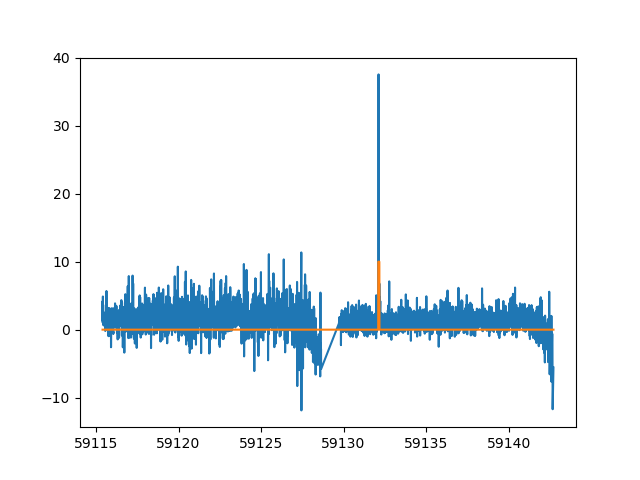

In [6]:
plt.figure()
plt.plot(test.lc['mjd'],test.lc['counts'])
plt.plot(test.lc['mjd'],test.lc['event']*10)

<IPython.core.display.Javascript object>


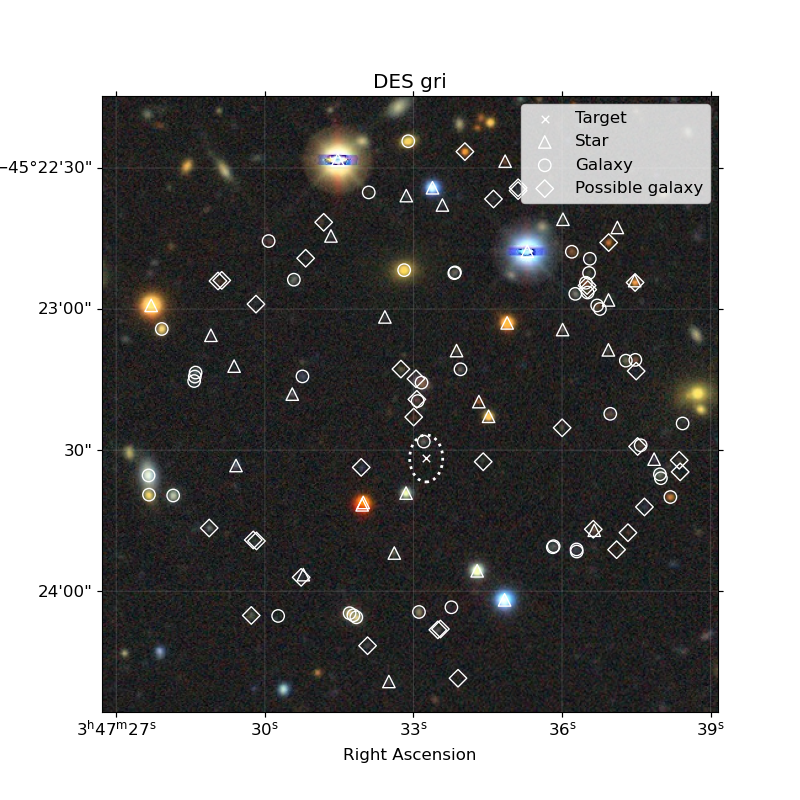

INFO: Query finished. [astroquery.utils.tap.core]
error ellipse


In [8]:
test.get_external()
coords = [c1.ra.deg,c1.dec.deg]
error = [test.era,test.edec]
ep._add_sources(test.fig,coords,test.cat,error)
ax = test.fig.get_axes()
#plt.plot(c2.ra.deg, c2.dec.deg,'wx',transform=ax[0].get_transform('fk5'),label='TESSELLATE position')
#plt.plot(c2.ra.deg, c2.dec.deg,'r+',transform=ax[0].get_transform('fk5'),label='TESSreduce PSF position')
#plt.plot(c3.ra.deg, c3.dec.deg,'rx',transform=ax[0].get_transform('fk5'),label='TESSreduce central pixel')

plt.legend()
#plt.savefig('localization_test.png')

In [9]:
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u

coord = SkyCoord(ra, dec, unit='deg', frame='galactic')
table = Irsa.query_region(coordinates=coord, spatial='Cone',catalog='fp_psc', radius=2 * u.arcmin)

<IPython.core.display.Javascript object>


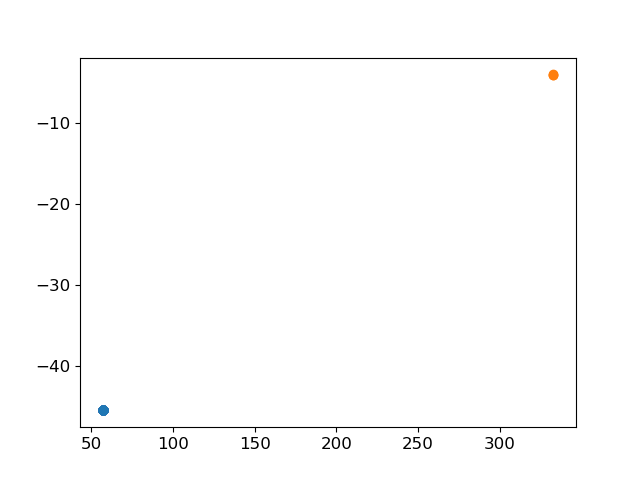

In [13]:
plt.figure()
plt.scatter(test.cat.ra,test.cat.dec)
plt.scatter(table['ra'],table['dec'])

In [42]:
def get_gaia(ra,dec,size):
    from astroquery.gaia import Gaia
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    Gaia.ROW_LIMIT = -1  # Ensure the default row limit.

    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')

    j = Gaia.cone_search_async(coord, radius=u.Quantity(100, u.arcsec))
    j = j.get_results().to_pandas()
    j['star'] = 1
    j.loc[(j['classprob_dsc_combmod_quasar'] > 0.7) | (j['classprob_dsc_combmod_galaxy'] > 0.7),'star'] = 2
    j.loc[(j['classprob_dsc_combmod_quasar'] > 0.9) | (j['classprob_dsc_combmod_galaxy'] > 0.9),'star'] = 0
    return j

In [ ]:
sbad = ep.simbad_sources(ra,dec,100/60**2)

In [15]:
cat = test.cat

In [16]:
dist = np.sqrt((j['ra'].values[:,np.newaxis] - cat['ra'].values[np.newaxis,:])**2 + (j['dec'].values[:,np.newaxis] - cat['dec'].values[np.newaxis,:])**2)*60**2



In [39]:
def check_gaia(cat,gaia):
    dist = np.sqrt((gaia['ra'].values[:,np.newaxis] - cat['ra'].values[np.newaxis,:])**2 + (gaia['dec'].values[:,np.newaxis] - cat['dec'].values[np.newaxis,:])**2)*60**2
    gind, catind = np.where(dist<5)
    cat['dist'] = np.nan
    cat['dist_l'] = np.nan
    cat['dist_u'] = np.nan
    if len(catind) > 0:
        cat.loc[catind,'star'] = gaia.loc[gind,'star'].values
        cat.loc[catind,'dist'] = gaia.loc[gind,'distance_gspphot'].values
        cat.loc[catind,'dist_l'] = gaia.loc[gind,'distance_gspphot_lower'].values
        cat.loc[catind,'dist_u'] = gaia.loc[gind,'distance_gspphot_upper'].values
        
    return cat

In [40]:
c = check_gaia(cat,j)

In [27]:
c

,quick_object_id,ra,dec,gmag,rmag,imag,zmag,mag_auto_g,mag_auto_r,mag_auto_i,...,extended_class_g,extended_class_r,extended_class_i,extended_class_z,star,otype,g-r,dist,dist_l,dist_u
0,11056600218029,56.891252,-45.405144,NaN,24.109463,NaN,NaN,NaN,24.230625,NaN,...,-9,2,-9,-9,2,none,NaN,NaN,NaN,NaN
1,11056600200371,56.885436,-45.405337,NaN,23.882800,23.470808,NaN,NaN,23.999561,23.419110,...,-9,1,2,-9,1,none,NaN,NaN,NaN,NaN
2,11056600274527,56.883642,-45.403223,24.357271,24.198349,NaN,NaN,24.051613,24.338377,NaN,...,2,2,-9,-9,2,none,0.158922,NaN,NaN,NaN
3,11056600382688,56.882694,-45.401545,22.099161,21.312330,20.991330,20.817810,21.823090,20.959133,20.539347,...,3,3,3,3,0,none,0.786831,NaN,NaN,NaN
4,11056600010942,56.882450,-45.401424,22.010403,21.116035,NaN,20.328682,21.315845,20.307116,NaN,...,3,3,-9,3,0,none,0.894368,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,11056600200722,56.889103,-45.376171,18.978480,18.713840,18.664738,18.664540,18.989964,18.726765,18.688889,...,0,0,0,0,0,none,0.264640,4955.507812,4862.136719,5055.409180
111,11056600391472,56.891829,-45.374035,24.211063,22.825867,21.276512,20.658384,23.900524,22.905375,21.414644,...,2,2,0,0,2,none,1.385196,NaN,NaN,NaN
112,11056600424821,56.895212,-45.374598,NaN,23.735857,NaN,22.674637,NaN,24.685051,NaN,...,-9,1,-9,2,1,none,NaN,NaN,NaN,NaN
113,11056600200723,56.887064,-45.373422,22.652939,20.951984,20.412200,20.183506,22.166935,20.376120,19.869165,...,3,3,3,3,0,none,1.700955,NaN,NaN,NaN


In [ ]:
def check_simbad(cat,sbad):
    dist = np.sqrt((sbad['ra'].values[:,np.newaxis] - cat['ra'].values[np.newaxis,:])**2 + (sbad['dec'].values[:,np.newaxis] - cat['dec'].values[np.newaxis,:])**2)*60**2
    sind, catind = np.where(dist<5)
    cat['otype'] = 'none'
    if len(catind) > 0:
        cat.loc[catind,'star'] = sbad.loc[sind,'star'].values
        cat.loc[catind,'otype'] = sbad.loc[sind,'otype'].values
    return cat

In [ ]:
test.cat.loc[catind,'star']

In [ ]:
sbad

In [20]:
cat

,quick_object_id,ra,dec,gmag,rmag,imag,zmag,mag_auto_g,mag_auto_r,mag_auto_i,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,extended_class_g,extended_class_r,extended_class_i,extended_class_z,star,otype,g-r
0,11056600218029,56.891252,-45.405144,NaN,24.109463,NaN,NaN,NaN,24.230625,NaN,...,0.332994,NaN,NaN,-9,2,-9,-9,2,none,NaN
1,11056600200371,56.885436,-45.405337,NaN,23.882800,23.470808,NaN,NaN,23.999561,23.419110,...,0.327849,0.203738,NaN,-9,1,2,-9,1,none,NaN
2,11056600274527,56.883642,-45.403223,24.357271,24.198349,NaN,NaN,24.051613,24.338377,NaN,...,0.405115,NaN,NaN,2,2,-9,-9,2,none,0.158922
3,11056600382688,56.882694,-45.401545,22.099161,21.312330,20.991330,20.817810,21.823090,20.959133,20.539347,...,0.029752,0.034750,0.052591,3,3,3,3,0,none,0.786831
4,11056600010942,56.882450,-45.401424,22.010403,21.116035,NaN,20.328682,21.315845,20.307116,NaN,...,0.024748,NaN,0.049337,3,3,-9,3,0,none,0.894368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,11056600200722,56.889103,-45.376171,18.978480,18.713840,18.664738,18.664540,18.989964,18.726765,18.688889,...,0.004660,0.006010,0.010236,0,0,0,0,2,none,0.264640
111,11056600391472,56.891829,-45.374035,24.211063,22.825867,21.276512,20.658384,23.900524,22.905375,21.414644,...,0.114768,0.053666,0.055936,2,2,0,0,2,none,1.385196
112,11056600424821,56.895212,-45.374598,NaN,23.735857,NaN,22.674637,NaN,24.685051,NaN,...,0.314471,NaN,0.462939,-9,1,-9,2,1,none,NaN
113,11056600200723,56.887064,-45.373422,22.652939,20.951984,20.412200,20.183506,22.166935,20.376120,19.869165,...,0.022869,0.020683,0.028094,3,3,3,3,0,none,1.700955


In [ ]:
test.cat.iloc[catind]

<IPython.core.display.Javascript object>


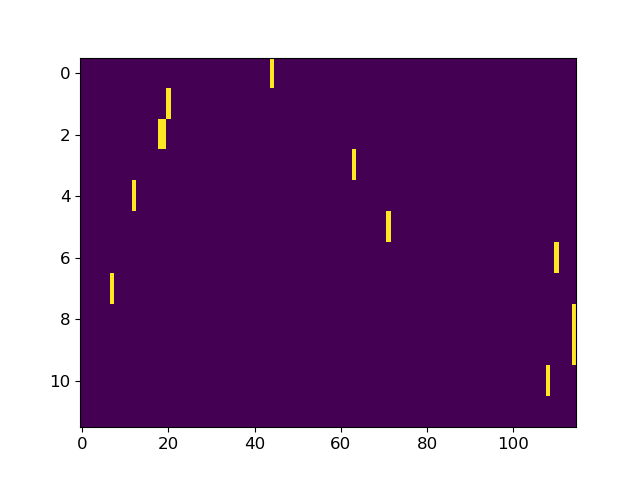

In [21]:
plt.figure()
plt.imshow(dist<2,aspect='auto')

In [24]:
from dl import queryClient as qc
query = f"""
    SELECT o.quick_object_id,o.ra, o.dec,o.raerr,
    o.mag_psf_g,o.mag_psf_r,o.mag_psf_i,o.mag_psf_z,
    o.mag_auto_g,o.mag_auto_r,o.mag_auto_i,o.mag_auto_z,
    o.magerr_psf_g,o.magerr_psf_r,o.magerr_psf_i,o.magerr_psf_z,
    o.magerr_auto_g,o.magerr_auto_r,o.magerr_auto_i,o.magerr_auto_z,
    o.extended_class_g, o.extended_class_r,o.extended_class_i,o.extended_class_z
    FROM delve_dr2.objects AS o
    WHERE q3c_radial_query(ra,dec,{ra},{dec},{})
    """
    
result = qc.query(sql=query,fmt='pandas')
result.replace(99.0,np.nan,inplace=True)
result['star'] = 0

queryClientError: Error: column o.raerr does not exist
LINE 1: copy (SELECT o.quick_object_id,o.ra, o.dec,o.raerr,
                                                   ^


In [35]:
sbadind = np.argmin(dist,axis=1)
catind = np.argmin(dist,axis=0)

In [38]:
catind

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0])

In [26]:
test.cat.iloc[ind]

,quick_object_id,ra,dec,gmag,rmag,imag,zmag,mag_auto_g,mag_auto_r,mag_auto_i,...,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,extended_class_g,extended_class_r,extended_class_i,extended_class_z,star,g-r
18,11056600010951,56.883188,-45.394900,23.602800,21.279980,18.347034,17.008856,23.461773,21.324625,18.371225,...,0.201004,0.031562,0.004965,0.002501,1,0,0,0,1,2.322820
108,11056600144712,56.865444,-45.383117,18.786179,17.351425,16.192259,15.721709,18.814138,17.368570,16.204426,...,0.004354,0.001851,0.001124,0.001058,0,0,0,0,2,1.434754


In [ ]:
sbad

In [ ]:
c3.separation(c4)

NameError: name 'query' is not defined

In [150]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
size = 1
coord = SkyCoord(ra, dec, unit=(u.deg, u.deg),frame='fk5')
simbad = Simbad()

simbad.add_votable_fields("otype")
sim = simbad.query_region(coord, radius= size * u.deg)
#sim = sim.to_pandas()
sim

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,int32
SIPS J0347-4523,03 47 31.8737,-45 23 43.410,14,14,0.212,0.207,90,A,O,2020yCat.1350....0G,Low-Mass*,1
Gaia DR3 4835164883509904128,03 47 22.9521,-45 22 55.056,14,14,0.516,0.459,90,A,O,2020yCat.1350....0G,Star,1
LEDA 527021,03 47 43.7,-45 25 01,5,5,--,--,0,D,O,2003A&A...412...45P,Galaxy,1
TYC 8067-1219-1,03 47 21.5759,-45 21 29.617,14,14,0.010,0.010,90,A,O,2020yCat.1350....0G,HighPM*,1
LCRS B034609.8-453119,03 47 47.1345,-45 22 08.823,14,14,1.163,1.172,90,A,O,2020yCat.1350....0G,Galaxy,1
GSF 64,03 47 49.33,-45 23 47.3,6,6,2500.000,2500.000,90,D,,1986MNRAS.221..233P,Galaxy,1
LEDA 130294,03 47 49.7382,-45 26 09.261,14,14,1.164,1.190,90,C,O,2020yCat.1350....0G,EmissionG,1
LEDA 526867,03 47 09.2,-45 25 48,5,5,--,--,0,D,O,2003A&A...412...45P,Galaxy,1


In [167]:
Simbad.list_votable_fields()#[["name", "description"]]

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [170]:

gal_query = f"""SELECT ra, dec, main_id, otype,

        FROM basic

        WHERE otype != 'star..'

        AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), CIRCLE('ICRS', {ra}, {dec} , {size})) = 1
        """
gal = Simbad.query_tap(query)
gal = gal.to_pandas()

star_query = f"""SELECT ra, dec, main_id, otype

        FROM basic

        WHERE otype = 'star..'

        AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), CIRCLE('ICRS', {ra}, {dec} , {size})) = 1
        """
stars = Simbad.query_tap(star_query)
stars = stars.to_pandas()

gal['star'] = 2
stars['star'] = 1
sbad = pd.concat([stars,gal])

In [171]:
gal

,ra,dec,main_id,rvz_redshift,otype,star
0,56.467670,-44.701090,LEDA 142207,0.003776,AG?,2
1,56.103812,-44.669339,6dFGS gJ034424.9-444009,0.003349,EmG,2
2,56.490413,-45.638133,LEDA 524567,0.071002,EmG,2
3,56.508625,-44.571750,6dFGS gJ034602.2-443418,0.083701,EmG,2
4,56.773648,-46.160071,2dFGRS TGS889Z255,0.105000,EmG,2
...,...,...,...,...,...,...
640,56.793798,-45.207167,2MASX J03471048-4512255,0.072317,G,2
641,55.494500,-45.366833,LCRS B034020.7-453131,NaN,G,2
642,55.786625,-45.411056,LCRS B034131.1-453406,NaN,G,2
643,57.670720,-45.529380,SMDG J0350410-453146,NaN,LSB,2


In [141]:
stars

ra,dec,main_id,otype
deg,deg,,
float64,float64,object,object
57.85546969703001,-45.48493093368,CD-45 1297,PM*
56.17755,-44.60687,[HMR2016] N1448 43058,Ce*
56.1679,-44.6214,[HMR2016] N1448 106396,Ce*
56.14883,-44.62816,[HMR2016] N1448 108839,Ce*
56.15928,-44.62687,[HMR2016] N1448 120930,Ce*
56.15922,-44.61608,[HMR2016] N1448 59273,Ce*
57.146261764070005,-46.13750738303,TYC 8067-1651-1,SB*
57.85479798143667,-45.28071788788723,Gaia DR3 4835485945201348096,*


In [128]:
simbad.get_votable_fields()

['main_id', 'coordinates', 'otype']

KeyError: 'ra'